# Simple policy iteration (with NN policy but no value function or baseline)

N.B. might randomly select an action with small reward, reinforce that behaviour, then select it more often and get more reinforcement (etc). However there may be another action available which would provide a higher reward, but by chance it gets chosen less often due to random fluctuations in early training, and thus receives less reinforcement overall. Shows problem of converging towards local reward maximum, not necessarily global one. Try to mitigate using smaller alpha (== learning rate) but doesn't seem to fix it. For example, the agent has not learned to fly below clouds, even though the immediate reward would be better.

We simulate an unobserved environment, which means that we only see what rewards are given by taking actions. We do not use an environment model to compute true expectation values but rely on our stochastic empirical rewards.

For some reason it cannot learn to perform descending actions to avoid clouds. I don't know why. I even added rewards for low-flying but they do not work. Might be a weird learning dynamics thing?

We do not consider forward planning here i.e. we do not use a value function, which means that we only optimise for immediate rewards. In general we would update using the empirical return instead of the immediate reward. This means that we have to run (possibly multiple) full episodes and store the trajectories before updating. This purely empirical approach is the MC method. Alternatively one could use a value function model and update using bootstraps with e.g. TD($\lambda$).

Policy gradients have high variance if we update using empirical rewards/returns. Could reduce using bootstrapping, but introducing bias. Can reduce variance in an unbiased way using baselines, which are constants which we subtract from the empirical returns in every state. A good baseline is the value function itself, i.e. we replace every $G_t$ with $G_t ~-~ v_{\pi_t}\left(s\right)$, and update the value-function model at the same time that we update the policy.

Since we use a NN, our solution may be limited by using too-simple a model, or by overtraining which causes poor generalisation. Generalisation is not a big problem here because the agent is exposed to all possible states during training and does not need to extrapolate when presented with a new environment.

In [1]:
import sys, time
import tensorflow       as tf
from   tensorflow       import keras
from   tensorflow.keras import layers, losses
import numpy as np
from matplotlib import lines as mlines, patches as mpatches, pyplot as plt

/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
available_CPUs = tf.config.list_physical_devices('CPU')
available_GPUs = tf.config.list_physical_devices('GPU')

for CPU in available_CPUs :
    print(f"CPU found: {CPU}")
    
for GPU in available_GPUs :
    print(f"GPU found: {GPU}")
    

CPU found: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
GPU found: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
###
###  Define additional tf objects
###

class LogLayer(layers.Layer):
    '''
    TensorFlow implementation of a NN layer which performs a log operation with no trainable weights.
    '''
    def __init__(self, name=None):
        super(LogLayer, self).__init__(name=name)
        
    def call(self, inputs):
        return tf.math.log(inputs)
    
class PolicyLoss(losses.Loss):
    '''
    TensorFlow implementation of the loss function used to train the policy
    Loss = sum_a R_a log p_a where p_a is model output and R_a is one-hot vector of rewards (non-zero
    component corresponds to the action taken). This is similar to cross-entropy where we would replace
    R_a with q_a for some categorical distribution q(a).
    '''
    def call(self, target, output, axis=-1):
        target = tf.convert_to_tensor(target)
        output = tf.convert_to_tensor(output)
        target.shape.assert_is_compatible_with(output.shape)
        return -tf.reduce_sum(target * tf.math.log(output), axis)
    

In [4]:

def get_height_above_SL(s) :
    '''Return current height above sea level for a given state s'''
    return s[0]

def get_next_space_has_cloud(s) :
    '''Return True if the next space has a cloud for a given state s'''
    return s[1]

def get_next_space_ground_height(s) :
    '''Return ground height in the next space for a given state s'''
    return s[2]

def get_distance_to_runway(s) :
    '''Return distance to runway for a given state s'''
    return s[3]

def generate_game_board(length=51) :
    '''
    Create a new game board with the desired length
    Inputs:
       length: int, default = 51
               length of the game board to create
    Returns:
       list of length length, types int : profile of ground heights as function of d
       list of length length, types bool: profile of is-cloud? as function of d
    '''
    ground_heights, is_clouds = [0, 0], [1, 1]
    ground_height , is_cloud  = ground_heights[0], is_clouds[0]
    ground_change = np.random.choice([-1, 0, 1], size=(length-3,), p=[0.4, 0.4, 0.2])
    for x_idx, delta_ground in enumerate(ground_change) :
        ground_height = min(2, max(0, ground_height + delta_ground))
        is_cloud      = np.random.choice([0,1], p=[.3, .7]) if is_cloud else np.random.choice([0,1], p=[.8, .2])
        ground_heights.append(ground_height)
        is_clouds     .append(is_cloud     )
    ground_heights.append(ground_heights[-1])
    is_clouds     .append(is_clouds     [-1])
    return ground_heights, is_clouds

def get_state(game_board, d, h) :
    '''
    Return the state representation for an agent in the current square
    Inputs:
       game_board: (list, list)
                   (profile of grounds heights, profile of is-cloud?) which define the game board
       d         : int
                   horizontal distance from start
       h         : int
                   vertical height
    '''
    ground_heights, is_clouds = game_board
    max_d                  = len(ground_heights) - 1
    h                      = min(3, max(0, h)) / 3
    next_space_g           = ground_heights[d+1] / 3 if d < max_d else 0
    next_space_has_cloud   = is_clouds     [d+1]     if d < max_d else 0
    distance_to_runway     = (max_d - d) / max_d
    sp = [h, next_space_g, next_space_has_cloud, distance_to_runway]
    return np.array(sp)
    
def get_next_state_and_reward(game_board, d, h, a) :
    ground_heights, is_clouds = game_board
    max_d = len(ground_heights) - 1
    # if already terminal state then don't do anything
    if d == max_d :
        raise ValueError(f"d={d} is a terminal state which I am not programmed to deal with")
    # if already crashed then don't do anything
    g = ground_heights[d]
    if d != 0 and h <= g :
        raise ValueError(f"h={h} is below the current ground height g={g} which should not be possible")
    # otherwise try to perform action
    r, new_d, new_h = 0, d, h
    hit_boundary = False
    if a in [0, 1, 2] : 
        new_d += 1
    if a in [3, 4, 5] : 
        new_d -= 1
        if new_d < 0 :
            hit_boundary = True
    if a in [0, 5] : 
        new_h += 1
        if new_h >= 4 :
            hit_boundary = True
    if a in [2, 3] : 
        new_h -= 1
        if new_h < 0 :
            hit_boundary = True
    if hit_boundary :
        r += -20.
        new_d, new_h = d, h
    # figure out if we've finished
    new_g = ground_heights[new_d]
    if new_d == max_d :
        if new_h != new_g :
            return new_d, new_h, -20.
        return new_d, new_h, 30.
    # figure out if we've crashed
    if new_d != 0 and new_h <= new_g :
        r += -20.
        new_d, new_h = d, h
    # figure out if we're in a cloud
    new_is_cloud = is_clouds[new_d]
    if new_h == 3 and new_g != 2 and new_is_cloud :
        r += -8.
    # reward a movement towards the goal
    r += (new_d - d)*10.
    # reward low flying
    r += 3 - new_h
    return new_d, new_h, r


In [5]:
def generate_directory_for_file_path(fname, print_msg_on_dir_creation=True) :
    """
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                                    if True then print a message whenever a new directory is created
    """
    while "//" in fname :
        fname = fname.replace("//", "/")
    dir_tree = fname.split("/")
    dir_tree = ["/".join(dir_tree[:i]) for i in range(1,len(dir_tree))]
    dir_path = ""
    for dir_path in dir_tree :
        if len(dir_path) == 0 : continue
        if not os.path.exists(dir_path) :
            os.mkdir(dir_path)
            if print_msg_on_dir_creation :
                print(f"Directory {dir_path} created")
            continue
        if os.path.isdir(dir_path) : 
            continue
        raise RuntimeError(f"Cannot create directory {dir_path} because it already exists and is not a directory")
    
    
def draw_game_board(game_board) :
    '''
    Inputs:
       game_board: (list, list)
                   (profile of grounds heights, profile of is-cloud?) which define the game board
    Returns:
       fig: plt.Figure object
            figure containing plot
       ax : plt.AxesSubplot object
            axes containing plot
    '''
    ground_heights, is_clouds = game_board
    length = len(ground_heights)
    fig = plt.figure(figsize=(15,4))
    ax  = fig.add_subplot(1, 1, 1)
    ax.tick_params(right=True, top=True, direction="in", labelsize=13)
    for i in range(length) : ax.axvline(i+0.5, c="gray", lw=0.4)
    for j in range(3) : ax.axhline(j+0.5, c="gray", lw=0.4)
    for idx, ground_height in enumerate(ground_heights) :
        if idx == 0 or idx == length - 1 :
            ax.fill_between([idx-0.5, idx+0.5], -0.5             , ground_height-0.5, color="palegreen")
            ax.fill_between([idx-0.5, idx+0.5], ground_height-0.5, ground_height+0.5, color="darkred")
        else :
            ax.fill_between([idx-0.5, idx+0.5], -0.5, ground_height+0.5, color="palegreen")
    for idx, is_cloud in enumerate(is_clouds) :
        if not is_cloud : continue
        ax.fill_between([idx-0.5, idx+0.5], 2.5, 3.5, color="lightgray")
    ax.set_xlim(-0.5, length-0.5)
    ax.set_ylim(-0.5, 3.5)
    ax.set_yticks([0, 1, 2, 3])
    return fig, ax


def draw_flightpath(game_board, flight_path, savefile="", show=False, dpi=300) :
    '''
    Create a plot showing the flightpath evaluated over the game board provided, using the policy provided
    '''
    ground_heights, is_clouds = game_board
    fig, ax     = draw_game_board(game_board)
    flight_path = np.array(flight_path)
    for d, h, a in flight_path :
        new_d, new_h = d, h
        if a in [0, 1, 2] : new_d += 1
        if a in [3, 4, 5] : new_d -= 1
        if a in [0, 5]    : new_h += 1
        if a in [2, 3]    : new_h -= 1
        ax.plot([d, new_d], [h, new_h], "--", c="red", lw=2)
    handles = [mpatches.Patch(facecolor='palegreen'), mpatches.Patch(facecolor='lightgray'), 
               mpatches.Patch(facecolor='darkred'), mlines.Line2D([], [], ls="--", lw=2, c="red")]
    labels  = ["Ground", "Clouds", "Runway", "Flight path"]
    ax.legend(handles, labels, loc=(0, 1.01), fontsize=15, ncol=4, frameon=False)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    if show :
        plt.show(fig)
    return fig, ax


In [19]:
###
###  Define network handling methods
###

def create_model(name=None) :
    inputs  = keras.Input(shape=(4,), name="_INPUT_h_gh_cloud_dtogo_", dtype='float32')
    x       = layers.Dense  (100, activation="relu"  , name="dense_1", dtype='float32')(inputs)
    x       = layers.Dense  (100, activation="relu"  , name="dense_2", dtype='float32')(x)
    x       = layers.Dense  (100, activation="relu"  , name="dense_3", dtype='float32')(x)
    x       = layers.Dense  (6  , activation="linear", name="dense_4", dtype='float32')(x)
    outputs = layers.Softmax(name="policy_values")(x)
    #outputs = LogLayer(name="log_policy_values")(x)
    model   = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

def play_training_game(model, max_epochs, length=21, verbose=True, alpha=0.01, optimizer=None) :
    game_board  = generate_game_board(length=length)
    epoch, d, h = 0, 0, 0
    if type(optimizer) is type(None) :
        optimizer = keras.optimizers.Adam(learning_rate=alpha)
    loss_fn     = PolicyLoss()
    net_return  = 0.
    while epoch < max_epochs and d < length-1 :
        with tf.GradientTape() as tape:
            state           = get_state(game_board, d, h)
            policy          = model(np.array([state]), training=True)
            policy_np       = policy.numpy()[0]
            action          = np.random.choice(6, p=policy_np)
            
            new_d, new_h, r = get_next_state_and_reward(game_board, d, h, action)
            r_vec = np.zeros(shape=(6,), dtype='float32')
            r_vec[action] = r
            loss_value = loss_fn(np.array([r_vec], dtype='float32'), policy)
            grads      = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            if verbose :
                updated_policy_np = model(np.array([state]), training=False).numpy()[0]
                print(f"Epoch started with position (d, h) = ({d}, {h})")
                print(f" - state is {state}")
                print(f" - policy is {policy_np}")
                print(f" - action is {['UR','R','DR','DL','L','UL'][action]}")
                print(f" - reward is {r}")
                print(f" - updated policy is {updated_policy_np}")
        d, h = new_d, new_h
        net_return += r
        epoch      += 1
    return net_return / (length-1)

def play_game(game_board, model, max_epochs, verbose=False) :
    epoch, d, h = 0, 0, 0
    flight_path = []
    max_d = len(game_board[0]) -1
    while epoch < max_epochs and d < max_d :
        state     = get_state(game_board, d, h)
        policy    = model(np.array([state]), training=True)
        policy_np = policy.numpy()[0]
        action    = np.random.choice(6, p=policy_np)
        flight_path.append((d, h, action))
        d, h, r   = get_next_state_and_reward(game_board, d, h, action)
        epoch += 1
        if verbose :
            print(f"Policy {policy_np} --> Action {action} --> New position ({d}, {h})")
    return flight_path


In [20]:
#
# Use multiple periods to simulate decaying learning rate (easier than using a lr strategy)
#

periods = [{"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.0001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.0001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.00001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.00001},
           {"num_games":500, "game_length":51, "max_epochs":20, "alpha":0.00001}]

model     = create_model(name="policy_model")
#model.summary()

start_time = time.time()

returns, running_returns = [], []
for period_idx, period in enumerate(periods) :
    num_games, game_length, max_epochs, alpha = period["num_games"], period["game_length"], period["max_epochs"], period["alpha"]
    optimizer = keras.optimizers.Adam(learning_rate=alpha)
    for game_idx in range(num_games) :
        running_return = np.nan if len(returns) < 50 else np.mean(returns[-50:])
        sys.stdout.write(f"\rPeriod {period_idx}: Running training game {game_idx+1} / {num_games} [t = {time.time()-start_time:.2f}s]  <last 50 mean return = {running_return:.3f}>")
        net_return = play_training_game(model, length=game_length, max_epochs=max_epochs, verbose=False, alpha=alpha, optimizer=optimizer)
        returns.append(net_return)
        running_returns.append(running_return)
    sys.stdout.write("\n")
    

Period 0: Running training game 28 / 500 [t = 4.42s]  <last 50 mean return = nan>

KeyboardInterrupt: 

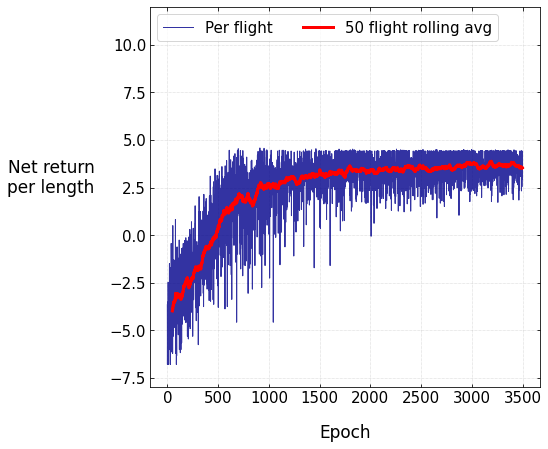

In [17]:

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(1, 1, 1)
ax.tick_params(right=True, top=True, direction="in", labelsize=15)
ax.plot(returns        , "-", lw=1, alpha=0.8, c="darkblue", label="Per flight")
ax.plot(running_returns, "-", lw=3, alpha=1.0, c="red"     , label="50 flight rolling avg")
ax.set_xlabel("Epoch", fontsize=17, labelpad=18)
ax.set_ylabel("Net return\nper length", fontsize=17, ha="right", rotation=0, labelpad=15)
ax.set_ylim([-8, 12])
ax.grid(ls=":", lw=0.5)
ax.legend(loc="upper left", frameon=True, fontsize=15, ncol=2)
plt.show(fig)


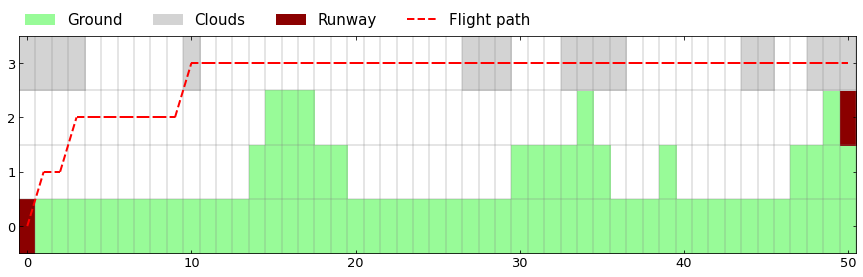

In [22]:

game_board  = generate_game_board(length=51)
flight_path = play_game(game_board, model, max_epochs=50, verbose=False)

fig, ax = draw_flightpath(game_board, flight_path, show=True)
plt.close(fig)